## Image Segmentation

### Imports

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift, estimate_bandwidth
# Required to calculate Dice Similarity Coefficient

from skimage.filters import threshold_mean
from skimage.color import rgb2gray

from PIL import Image

# Reduce size of original image to reduce computation time
size = (256, 256)

#### Function for generating masks from labels

In [ ]:
def generate_mask_list(labels, l):
    out = []
    for i in l:
        if i == 0:
            continue
        out.append(labels == i)
    return out

#### Function for calculating DSC

In [ ]:
def calculate_DSC(im1, im2):
    n = np.count_nonzero(im1 & im2)
    a = np.count_nonzero(im1)
    b = np.count_nonzero(im2)
    return 2 * n / (a + b)

#### Function for displaying images

In [90]:
def plot_two_images(figure_title, image1, label1, image2, label2, 
                    cmap1=None, cmap2=None):
    
    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image1, cmap = cmap1)
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(image2, cmap = cmap2)
    plt.axis('off')
    plt.title(label2)

    plt.show()

#### Function for applying MeanShift algorithm

In [103]:
def apply_meanshift(img):
    
    # TODO: Apply MeanShift to image
    # Consider the following hints as per the lab specification

    # Step 1 - Extract the three RGB colour channels
    img = np.array(img)

    red_channel = img[:,:,0]
    blue_channel = img[:,:,1]
    green_channel = img[:,:,2]

    # Step 2 - Store original image shape to be used later in resizing
    # Combine the three colour channels by flattening each channel
    # Then stack the flattened channels together
    # This gives the "colour_samples"
    h, w, _ = img.shape
    red_channel = red_channel.ravel()
    green_channel = green_channel.ravel()
    blue_channel = blue_channel.ravel()

    colour_samples = np.column_stack((red_channel, green_channel, blue_channel))
    
    
    # Step 3 - Perform MeanShift clustering
    # For larger images this may take a few minutes to compute

    # b = estimate_bandwidth(colour_samples)
    # print(b)
    ms_clf = MeanShift(bin_seeding=True, bandwidth=53.68536908596792)
    ms_labels = ms_clf.fit_predict(colour_samples)

    # Step 4 - Reshape ms_labels back to the original image shape
    # for displaying the segmentation output
    ms_labels = ms_labels.reshape(h, w)

    return ms_labels

#### Function for applying Watershed algorithm

In [113]:
def apply_watershed(img, threshold=None, plotDistTransform = False):
    
    # TODO: Apply Watershed to image
    # Consider the following hints as per the lab specification

    # Step 1 - Convert the image to grayscale and then binary
    # and convert the image to a numpy matrix
    img_grey = img.convert('L')
    
    # Convert to binary image (note: can also use cv thresholding)
    if threshold is not None:
        img_grey = img_grey.point(lambda x: 255 if x < threshold else 0, '1')

    img_array = np.array(img_grey)
    
    # Step 2 - Calculate the distance transform
    # Hint: Use ndi.distance_transform_edt(img_array)
    distance = ndi.distance_transform_edt(img_array)

    # Remember to plot distance transform for Task 2
    if plotDistTransform:
        # plt.imshow(distance, cmap=None)
        # plt.axis('off')
        # plt.title("Distance Plot")
        plot_two_images('Steps', img_grey, 'Greyscale', distance, 'Distance')

    # Step 3 - Generate the Watershed markers
    # Hint: Use the peak_local_max() function from the skimage.feature library
    # to get the local maximum values and then convert them to markers
    # Remember to change the local search region for good segmentation results
    # using ndi.label() (note the markers are the 0th output of this function)
    local_max = peak_local_max(distance, indices=False, min_distance=16, labels=img_array)
    markers, _ = ndi.label(local_max)

    # Step 4 - Perform Watershed and store the labels
    # Hint: Use the watershed() function from the skimage.morphology library
    # with three inputs: -distance, markers and your image array as a mask
    ws_labels = []
    ws_labels = watershed(-distance, markers, mask=img_array)

    
    return ws_labels, distance

### Q1. Use the MeanShift algorithm for image segmentation

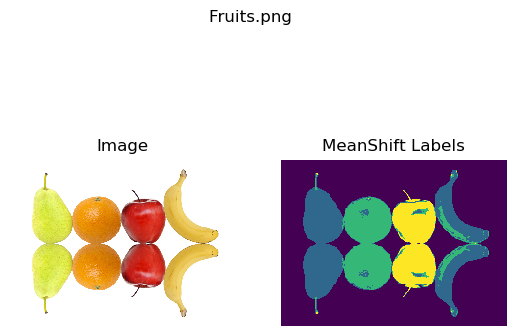

In [104]:
# Specify path to the test image
img_path = 'Fruits.png'

# Read image
img = Image.open(img_path)
img.thumbnail(size)

# Apply MeanShift algorithm to the image
ms_labels = apply_meanshift(img)

# Read and plot the original image and MeanShift result
img = Image.open(img_path)

plot_two_images(img_path, img, "Image", ms_labels, "MeanShift Labels")

### Q2. Use Watershed transformation for image segmentation

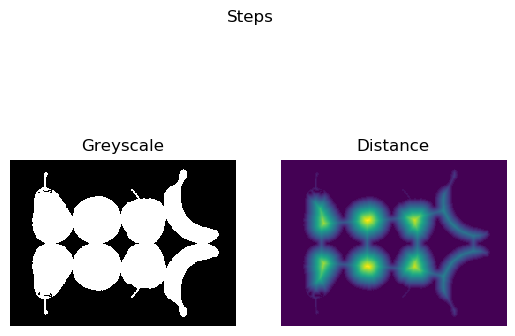

/tmp/ipykernel_65132/1265285919.py:32: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance, indices=False, min_distance=16, labels=img_array)


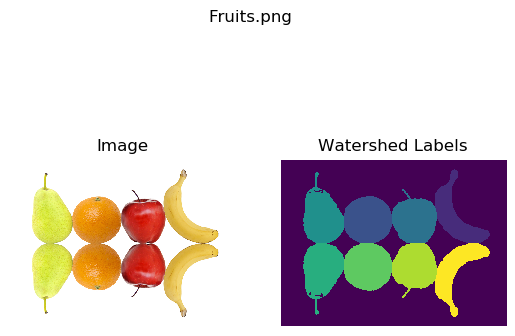

In [114]:
# Read image from img_path as specified abovesize = (256, 256)

img = Image.open(img_path)
img.thumbnail(size)

# Apply Watershed algorithm (remember to plot distance transform as well)
t = threshold_mean(img)
ws_labels, distance = apply_watershed(img, threshold=t+20, plotDistTransform=True)

# Read the original image
img = Image.open(img_path)

plot_two_images(img_path, img, "Image", ws_labels, "Watershed Labels")

### Q3. Compare MeanShift and Watershed segmentation results

In [157]:
# List of MaskX.png images
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,9)]

# Generate list of unique MeanShift labels and corresponding label image masks
lbl_ms_unique = np.unique(ms_labels)
ms_masks = generate_mask_list(ms_labels, lbl_ms_unique)

# Generate list of unique Watershed labels and corresponding label image masks
# Hint: Make sure you have generated reasonable watershed segmentation results
lbl_ws_unique = np.unique(ws_labels)
ws_masks = generate_mask_list(ws_labels, lbl_ws_unique)

# Iterate over MaskX.png images and calculate DSC
for each_maskx_image in MaskX:
    # Read each MaskX.png image
    im1 = Image.open(each_maskx_image)
    im1.thumbnail(size)

    # Check DSC for each MeanShift label
    ms_DSC = [calculate_DSC(im1, mask) for mask in ms_masks]
    ms_DSC = max(ms_DSC)
    
    # Check DSC for each Watershed label
    ws_DSC = [calculate_DSC(im1, mask) for mask in ws_masks]
    ws_DSC = max(ws_DSC)

    print(f'[{each_maskx_image}]  |  Meanshift: {ms_DSC:.4f}  |  Watershed: {ws_DSC:.4f}')

[Mask1.png]  |  Meanshift: 0.4171  |  Watershed: 0.9295
[Mask2.png]  |  Meanshift: 0.5555  |  Watershed: 0.9471
[Mask3.png]  |  Meanshift: 0.6164  |  Watershed: 0.9396
[Mask4.png]  |  Meanshift: 0.2849  |  Watershed: 0.9209
[Mask5.png]  |  Meanshift: 0.4199  |  Watershed: 0.9298
[Mask6.png]  |  Meanshift: 0.5578  |  Watershed: 0.9491
[Mask7.png]  |  Meanshift: 0.6164  |  Watershed: 0.9397
[Mask8.png]  |  Meanshift: 0.2860  |  Watershed: 0.9125


#### Discussion

The watershed segmentation algorithm performed significantly better in this task compared to the Meanshift algorithm. This is because the image had multiple fruits with distinct contours.

We can expect Meanshift clustering to perform significantly better in situations where the contours are not so clear, and we can rather use colour clusters to differentiate objects